In [ ]:
# default_exp modelling

# Modelling meter readings

> API details.

In [1]:
#export
import pandas as pd
from pathlib import Path
import os
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import typing

from sklearn import linear_model, tree, model_selection, ensemble

from fastai.tabular.all import *

In [2]:
pd.options.plotting.backend = "plotly"

In [3]:
base_path = Path("../data")

In [4]:
csvs = sorted([base_path/v for v in os.listdir(base_path) if v.endswith('.csv')])
csvs

[Path('../data/building_metadata.csv'),
 Path('../data/sample_submission.csv'),
 Path('../data/test.csv'),
 Path('../data/train.csv'),
 Path('../data/weather_test.csv'),
 Path('../data/weather_train.csv')]

In [5]:
train_csv = csvs[3]
train_weather_csv = csvs[-1]
test_csv = csvs[2]
test_weather_csv = csvs[-2]
meta_csv = csvs[0]

train_csv, train_weather_csv, test_csv, test_weather_csv, meta_csv

(Path('../data/train.csv'),
 Path('../data/weather_train.csv'),
 Path('../data/test.csv'),
 Path('../data/weather_test.csv'),
 Path('../data/building_metadata.csv'))

In [6]:
#export
def numpy_evaluate(y_true:np.ndarray, y_pred:np.ndarray): return np.sqrt(np.mean((y_pred  - y_true)**2))

def evaluate_torch(y_true:torch.Tensor, y_pred:torch.Tensor): return torch.sqrt(torch.mean((y_pred - y_true)**2))

## Loading

In [7]:
%%time
train = pd.read_csv(train_csv, parse_dates=['timestamp'])
train.head()

CPU times: user 9.33 s, sys: 780 ms, total: 10.1 s
Wall time: 10.1 s


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [8]:
%%time
test = pd.read_csv(test_csv, parse_dates=['timestamp'])
test.head()

CPU times: user 18.7 s, sys: 2.3 s, total: 21 s
Wall time: 21 s


,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01
1,1,1,0,2017-01-01
2,2,2,0,2017-01-01
3,3,3,0,2017-01-01
4,4,4,0,2017-01-01


In [9]:
%%time
weather_train = pd.read_csv(train_weather_csv, parse_dates=['timestamp'])
weather_train.head()

CPU times: user 108 ms, sys: 4 ms, total: 112 ms
Wall time: 110 ms


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [10]:
%%time
weather_test = pd.read_csv(test_weather_csv, parse_dates=['timestamp'])
weather_test.head()

CPU times: user 220 ms, sys: 8 ms, total: 228 ms
Wall time: 226 ms


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


In [11]:
%%time
building = pd.read_csv(meta_csv)
building.head()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.02 ms


,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


## sklearn pipeline

### Preparing the model input and output

In [12]:
metering_input_cols = ['meter'] # 'building_id', 'timestamp']
output_col = 'meter_reading'

In [ ]:
#export
def get_Xy(metering:pd.DataFrame,
           metering_input_cols:typing.List[str],
           output_col:str='meter_reading',
           is_train:bool=True):
    
    X = metering.loc[:,metering_input_cols]
    if is_train:
        y = np.log(1+metering[output_col].values.ravel())
        
    if is_train:
        return X, y
    return X, None

In [ ]:
%%time
X, y = get_Xy(train, metering_input_cols=metering_input_cols,
              is_train=True)

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.2)

In [ ]:
X_train.values.shape, y_train.shape

In [ ]:
X_train[:5], y_train[:5], X_test[:5], y_test[:5]

### Training

In [ ]:
m = linear_model.LinearRegression()

In [ ]:
m.fit(X_train, y_train)

In [ ]:
y_pred = m.predict(X_train)

### Evaluation

In [ ]:
%%time
numpy_evaluate(y_train, y_pred)

In [ ]:
%%time
numpy_evaluate(y_test, m.predict(X_test))

Finding:
- Linear model + meter as input only + random 80-20 split  $\Rightarrow$ 2.14

## fastai overkill

### Radically merging all the data

In [13]:
#export
def radical_merging(df:pd.DataFrame, building:pd.DataFrame, 
                    weather:pd.DataFrame, n_sample:int=None,):
    

    bid_col = 'building_id'
    sid_col = 'site_id'
    time_col = 'timestamp'
    target_col = 'meter_reading'
    
    categorical = [bid_col, sid_col, 'meter', 'primary_use', 'cloud_coverage']
    continuous = ['square_feet', 'year_built', 'floor_count', 
                  'air_temperature', 'dew_temperature',
                  'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
                  'wind_speed']


    X = df.loc[:,[bid_col, 'meter', target_col, time_col]].copy()


    X = pd.merge(X, building, on=bid_col, how='left')


    X = pd.merge(X, weather, on=[sid_col, time_col], how='left')


    #return_cols =  categorical + continuous + [target_col,]  # time_col

    #X = X.loc[:,return_cols]
    if n_sample is not None:
        X = X.sample(n_sample)
        
    X[target_col] = np.log(X[target_col] + 1)
    X = add_datepart(X, time_col)
    """
    """
    categorical.extend(['timestampMonth', 'timestampWeek', 'timestampDay',
                        'timestampDayofweek', 'timestampDayofyear', 'timestampIs_month_end',
                        'timestampIs_month_start', 'timestampIs_quarter_end',
                        'timestampIs_quarter_start', 'timestampIs_year_end',
                        'timestampIs_year_start'])
    
    continuous.extend(['timestampYear', 'timestampElapsed'])
        
    X = X.loc[:, [col for col in X.columns.values if col not in [time_col]]]
    
    missing_cont = [col for col in continuous if col not in X.columns]
    missing_cat = [col for col in categorical if col not in X.columns]
    assert len(missing_cat) == 0, f'{missing_cat} not in X!'
    assert len(missing_cont) == 0, f'{missing_cont} not in X!'
    
    X.loc[:,continuous] = X.loc[:,continuous].astype(float)
    X.loc[:,categorical] = X.loc[:,categorical].astype('category')
    
    return X, continuous, categorical

In [49]:
%%time
n_sample = None
X, continuous, categorical = radical_merging(train, building, weather_train,
                    n_sample=n_sample)

/home/eric/.conda/envs/py38_fastai/lib/python3.8/site-packages/fastai/tabular/core.py:33: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())


CPU times: user 46.1 s, sys: 14.8 s, total: 1min
Wall time: 1min


In [15]:
X.head().T

,7622815,14315440,7023631,14499301,11611176
building_id,1090,987,114,1249,1200
meter,0,1,0,3,2
meter_reading,5.64659,7.03229,6.67803,6.08808,4.42715
site_id,13,9,1,14,13
primary_use,Office,Education,Education,Office,Entertainment/public assembly
square_feet,305047,166395,139683,159384,545351
year_built,NaN,NaN,1958,NaN,NaN
floor_count,NaN,NaN,13,NaN,NaN
air_temperature,15,35,15.8,20.6,20
cloud_coverage,4,2,NaN,0,6


In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 28 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   building_id                category
 1   meter                      category
 2   meter_reading              float64 
 3   site_id                    category
 4   primary_use                category
 5   square_feet                float64 
 6   year_built                 float64 
 7   floor_count                float64 
 8   air_temperature            float64 
 9   cloud_coverage             category
 10  dew_temperature            float64 
 11  precip_depth_1_hr          float64 
 12  sea_level_pressure         float64 
 13  wind_direction             float64 
 14  wind_speed                 float64 
 15  timestampYear              float64 
 16  timestampMonth             category
 17  timestampWeek              category
 18  timestampDay               category
 19  timestampDayofweek 

In [17]:
continuous, categorical

(['square_feet',
  'year_built',
  'floor_count',
  'air_temperature',
  'dew_temperature',
  'precip_depth_1_hr',
  'sea_level_pressure',
  'wind_direction',
  'wind_speed',
  'timestampYear',
  'timestampElapsed'],
 ['building_id',
  'site_id',
  'meter',
  'primary_use',
  'cloud_coverage',
  'timestampMonth',
  'timestampWeek',
  'timestampDay',
  'timestampDayofweek',
  'timestampDayofyear',
  'timestampIs_month_end',
  'timestampIs_month_start',
  'timestampIs_quarter_end',
  'timestampIs_quarter_start',
  'timestampIs_year_end',
  'timestampIs_year_start'])

In [18]:
#export
def split_dataset(X:pd.DataFrame, split_kind:str='random',
                  train_frac:float=8):
    
    def random_split():
        n_train = int(len(X)*train_frac)
        train_bool = X.index.isin(np.random.choice(X.index.values, size=n_train, replace=False))
        return train_bool
    
    def time_split():
#        print(X.columns)
        time_col = 'timestampElapsed'
        ts = X[time_col].sort_values(ascending=True)
#        print(ts)
        ix = int(len(X)*train_frac)
#        print('ix', ix)
        threshold_t = ts.iloc[ix:].values[0]
#        print('threshold_t', threshold_t)
        return X[time_col] < threshold_t
    
    split_funs = {
        'random': random_split,
        'time': time_split,
    }
    
    assert split_kind in split_funs
    train_bool = split_funs[split_kind]()
    
    train_idx = np.where(train_bool)[0]
    valid_idx = np.where(~train_bool)[0]

    return (list(train_idx), list(valid_idx))

In [51]:
%%time
split_kind = 'random'
#split_kind = 'time'
#splits = split_dataset(X, split_kind=split_kind, train_frac=.8)
splits=None

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 6.41 ms


In [20]:
sorted(X.iloc[splits[0]].loc[:, 'timestampMonth'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [ ]:
X.info()

Super simplistic input data

In [21]:
%%time
procs = [Categorify, FillMissing, Normalize]
to = TabularPandas(X, procs, ['meter'],
                   [], y_names='meter_reading', splits=splits)

CPU times: user 72 ms, sys: 0 ns, total: 72 ms
Wall time: 86.3 ms


All input data

In [58]:
%%time
procs = [Categorify, FillMissing, Normalize]
to = TabularPandas(X, procs, categorical,
                   continuous, y_names='meter_reading', splits=splits)

CPU times: user 3min 15s, sys: 11.9 s, total: 3min 27s
Wall time: 3min 27s


In [34]:
to.train.xs

,building_id,site_id,meter,primary_use,cloud_coverage,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,timestampDayofyear,...,year_built,floor_count,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timestampYear,timestampElapsed
14315440,988,10,2,1,3,9,37,17,6,261,...,0.080364,-0.119288,1.752461,1.381249,-0.096668,-0.492926,0.062007,-0.560048,0.0,0.725373
7023631,115,2,1,1,0,5,19,10,2,131,...,-0.540858,5.749377,-0.014284,0.797441,-0.096668,-1.571569,-1.026462,-0.338741,0.0,-0.507203
14499301,1250,15,4,7,1,9,38,21,3,265,...,0.080364,-0.119288,0.427403,1.153663,-0.096668,0.425374,1.422593,-0.825617,0.0,0.756191
18618247,1162,14,2,7,0,12,48,3,6,338,...,0.080364,-0.119288,-1.624598,-1.369576,-0.096668,1.678924,0.696947,-0.117433,0.0,1.451083
5579339,939,10,1,5,1,4,15,15,5,106,...,0.080364,-0.119288,-0.032687,0.550065,-0.096668,-0.390891,-1.117168,-0.825617,0.0,-0.750951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150223,980,10,3,2,1,2,6,8,1,39,...,0.080364,-0.119288,0.068532,-1.696113,-0.096668,1.387400,1.513299,1.475981,0.0,-1.379094
6705941,1009,11,4,1,1,5,18,5,4,126,...,0.080364,-0.706154,0.114541,-0.548286,-0.096668,-1.003093,-0.119405,-0.117433,0.0,-0.560931
18596981,1081,14,3,1,0,12,48,3,6,338,...,0.080364,-0.119288,-1.523378,-1.260730,-0.096668,1.547735,0.696947,0.325182,0.0,1.447135
13510055,710,6,1,1,0,9,35,3,6,247,...,0.390975,-0.706154,0.188156,0.916182,-0.096668,0.002660,0.787653,1.254674,0.0,0.590260


In [35]:
to.train.ys

,meter_reading
14315440,7.032289
7023631,6.678028
14499301,6.088081
18618247,0.000000
5579339,2.251292
...,...
2150223,4.836679
6705941,1.993352
18596981,6.662174
13510055,1.526056


### Modelling with sklearn

In [53]:
m = linear_model.LinearRegression()

In [ ]:
m = ensemble.RandomForestRegressor(n_estimators=100, max_features=.75, criterion='mse')

In [54]:
%%time
m.fit(to.train.xs, to.train.ys.values.ravel())

CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 50.2 ms


LinearRegression()

In [55]:
evaluate_torch(torch.from_numpy(to.valid.ys.values), 
               torch.from_numpy(m.predict(to.valid.xs.values).ravel()))

tensor(2.3323, dtype=torch.float64)

### Modelling with fastai

In [59]:
dls = to.dataloaders()

In [ ]:
y_range = [np.min([to.train.ys.values.min(), to.valid.ys.values.min()]),
           np.max([to.train.ys.values.max(), to.valid.ys.values.max()]),]
y_range

In [65]:
y_range = [to.train.ys.values.min(),
           to.train.ys.values.max()]
y_range

[0.0, 16.902212]

In [66]:
learn = tabular_learner(dls, y_range=y_range, layers=[500,250],
                        n_out=1, loss_func=evaluate_torch)

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.0014454397605732083)

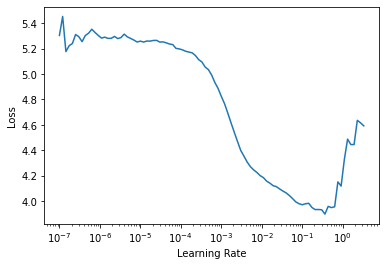

In [67]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time


In [46]:
preds, targs = learn.get_preds()

In [47]:
preds, targs

(tensor([[5.8980],
         [0.1494],
         [3.6583],
         ...,
         [5.2112],
         [4.5638],
         [3.3567]]),
 tensor([[5.6466],
         [4.4271],
         [3.3935],
         ...,
         [5.1401],
         [4.9075],
         [3.6016]]))

In [48]:
evaluate_torch(targs, preds)

tensor(0.9828)

**randomly splitting**
    
Finding (modified target values, all info = info except time):
- Linear:
    - meter only @100k: 2.1
    - all info minus time @100k: 2.3
    - all info incl time @100k: 2.32
    - all info incl time + ids @100k: 2.32
- RandomForest:
    - meter only @100k: 2.2
    - all info minus time @100k: 2.7
    - all info incl time @100k: 2.74
    - all info incl time + ids @100k: 2.82
- tabular_learner:
    - meter only @100k: 2.1
    - all info minus time @100k: 1.56
    - all info incl time @100k: 1.52
    - all info incl time + ids @100k: 0.96
    
**splitting along time**
Finding:
- Linear:
    - meter only @100k: 2.1
    - all info minus time @100K: 2.2
    - all info incl time @100k: 2.3
    - all info incl time + ids @100k: 2.29
- RandomForest:
    - meter only @100k: 2.1
    - all info minus time @100K: 2.7
    - all info incl time @100k: 2.52
    - all info incl time + ids @100k: 2.62
- tabular_learner:
    - meter only @100k: 2.06
    - all info minus time @100K: 1.62
    - all info incl time @100k: 1.62
    - all info incl time + ids @100k: 1.31